# Computation-Aware Gaussian Processes

In [1]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import tueplots
from tueplots import bundles
plt.rcParams.update(bundles.neurips2022())

# Scientific computing
import numpy as np
import itergp
from probnum import backend, linops, randvars
from probnum.randprocs import kernels

from itergp import GaussianProcess, datasets, methods

# Drug Discovery

Suppose we are trying to develop a new effective drug for a disease, say cancer. We know of several candidate proteins which were synthesized and tested in small-scale studies or even sold, but might be expensive or not as effective as we like. Our goal is to find a new drug candidate. 

In [80]:
rng_state = backend.random.rng_state(42)

num_data = 100
input_shape = ()
output_shape = ()

length_scale = 0.2
noise_scale = 0.15

kernel0_latent_fn = kernels.Matern(input_shape, lengthscale=length_scale, nu=3.5)
kernel1_latent_fn = kernels.Matern(input_shape, lengthscale=0.02)

(
    rng_state_latent0,
    rng_state_latent1,
    rng_state_rweights0,
    rng_state_rweights1,
    rng_state,
) = backend.random.split(rng_state, num=5)

# Sample medical candidate molecules
n_candidates = 15
X_candidates = backend.random.uniform(
        rng_state_latent1,
        shape=(n_candidates,) + input_shape,
        minval=-1.0,
        maxval=1.0,
    )
rweights_candidates = backend.random.uniform(
    rng_state_rweights1, shape=(n_candidates,), minval=0.0, maxval=1.5
) ** 2
X_toxic_candidates = X_candidates[rweights_candidates > 1.5]
X_drug_candidates = X_candidates[(rweights_candidates <= 1.5) & (rweights_candidates > 0.25)]

latent_fn = lambda x: kernel0_latent_fn.matrix(
    x,
    backend.random.uniform(
        rng_state_latent0,
        shape=(10,) + input_shape,
        minval=-1.0,
        maxval=1.0,
    ),
) @ backend.random.uniform(
    rng_state_rweights0, shape=(10,), minval=-0.5, maxval=1.0
) + kernel1_latent_fn.matrix(
    x,
    X_candidates,
) @ rweights_candidates

# Generate data
rng_state_X, rng_state_y = backend.random.split(rng_state, num=2)
X = backend.random.uniform(
    rng_state=rng_state_X, shape=(num_data,) + input_shape, minval=-1.25, maxval=1.25
)
y = latent_fn(X) + noise_scale * backend.random.standard_normal(
    rng_state=rng_state_y, shape=(num_data,) + output_shape
)

Xnew = backend.linspace(-1.25, 1.25, 1000)


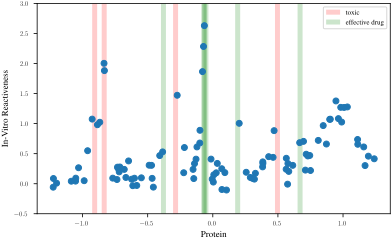

In [86]:
with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, ax = plt.subplots()
    ax.scatter(X, y)
    ax.plot(Xnew, latent_fn(Xnew), color="black", alpha=0.2)
    ylim0, ylim1 = -0.5, 3.0
    ax.vlines(X_toxic_candidates, ylim0, ylim1, color="red", alpha=0.2, linewidth=5, zorder=0, label="toxic")
    ax.vlines(X_drug_candidates, ylim0, ylim1, color="green", alpha=0.2, linewidth=5, zorder=0, label="effective drug")
    ax.set(xlabel="Protein", ylabel="In-Vitro Reactiveness")
    ax.set_ylim([ylim0, ylim1])
    ax.legend()

Now, one big issue with drug design is that drug candidates often later turn out to be toxic. Therefore, we want to not only find the best candidate among a potential set of new protein drugs, but find a whole set of them, which should be sufficiently different in their structure to avoid all of them being toxic.

We have a finite computational budget available, since we need to get the drug to market as quickly as possible, and we can only test a small amount of molecules in-vivo since this is very expensive. How can we identify drug candidates effectively?

# Gaussian Processes

## Scaling to Large Datasets

## Computation-Aware Inference